In [1]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
meta = pd.read_csv('metadata.csv')
meta

videoname  original_width  original_height label        original
0      aznyksihgl.mp4             129              129  FAKE  xnojggkrxt.mp4
1      gkwmalrvcj.mp4             129              129  FAKE  hqqmtxvbjj.mp4
2      lxnqzocgaq.mp4             223              217  FAKE  xjzkfqddyk.mp4
3      itsbtrrelv.mp4             186              186  FAKE  kqvepwqxfe.mp4
4      ddvgrczjno.mp4             155              155  FAKE  pluadmqqta.mp4
...               ...             ...              ...   ...             ...
95629  rqcsjlsmiz.mp4             129              129  FAKE  pbsccacgff.mp4
95630  xjmnerypjf.mp4              90               90  FAKE  qrjydgidga.mp4
95631  hnewpzhihy.mp4              75               75  FAKE  vabhbfiifl.mp4
95632  okbarlnmwm.mp4             268              267  FAKE  uqaaspbgtz.mp4
95633  asddammewq.mp4              90               90  FAKE  yfjkgiynbi.mp4

[95634 rows x 5 columns]

In [4]:
meta.shape

(95634, 5)

In [5]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

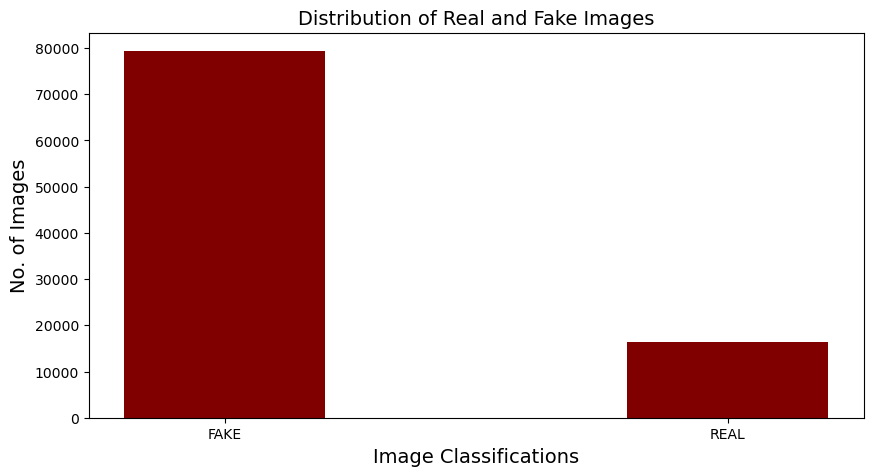

In [6]:
fig = plt.figure(figsize = (10, 5))

plt.bar(list(meta['label'].unique()), list(meta['label'].value_counts().values), color ='maroon', width = 0.4)
 
plt.xlabel("Image Classifications")
plt.ylabel("No. of Images")
plt.title("Distribution of Real and Fake Images")
plt.show()

In [7]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [8]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [9]:
Train_set.shape,Val_set.shape,Test_set.shape

((8960, 5), (3840, 5), (3200, 5))

In [10]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

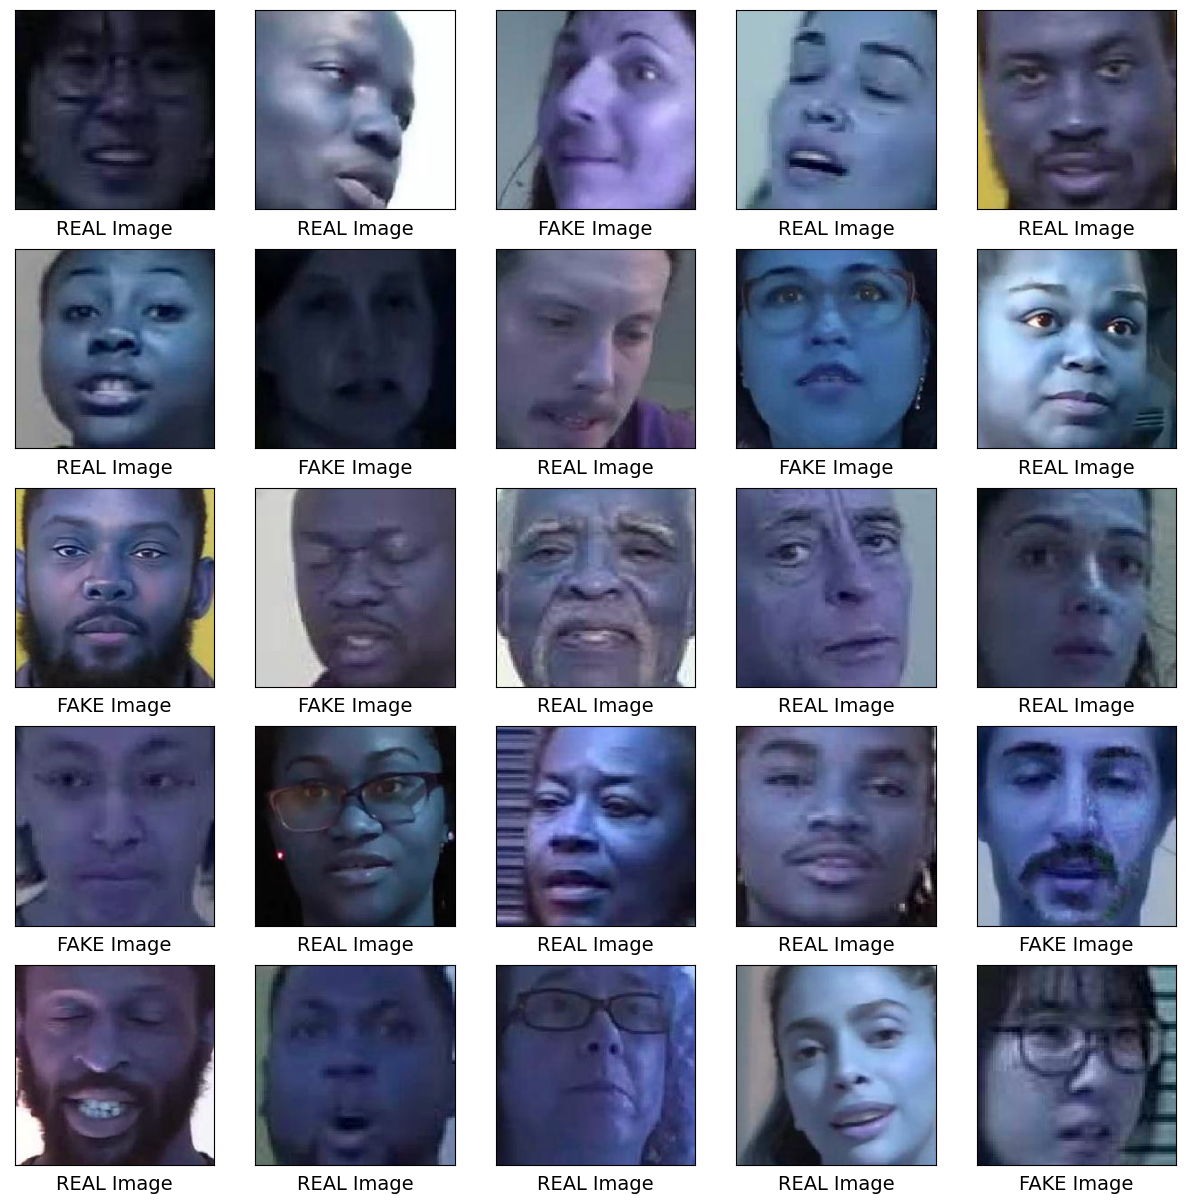

In [11]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

In [12]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [13]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [14]:
from functools import partial

tf.random.set_seed(42); 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal");

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
]);

Metal device set to: Apple M2


2022-12-03 16:18:55.833155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-03 16:18:55.833247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 401408)            0

In [16]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val));

Epoch 1/5


2022-12-03 16:18:56.455148: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-03 16:18:56.815670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - ETA: 0s - loss: 183.0308 - accuracy: 0.5060

2022-12-03 16:21:27.658061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 173s 1s/step - loss: 183.0308 - accuracy: 0.5060 - val_loss: 0.6930 - val_accuracy: 0.5029
Epoch 2/5
140/140 [==============================] - 172s 1s/step - loss: 0.6947 - accuracy: 0.5026 - val_loss: 0.6935 - val_accuracy: 0.5089
Epoch 3/5
140/140 [==============================] - 169s 1s/step - loss: 0.6934 - accuracy: 0.5112 - val_loss: 0.6947 - val_accuracy: 0.4917
Epoch 4/5
140/140 [==============================] - 179s 1s/step - loss: 0.7250 - accuracy: 0.5069 - val_loss: 0.6946 - val_accuracy: 0.4961
Epoch 5/5
140/140 [==============================] - 180s 1s/step - loss: 0.6942 - accuracy: 0.5145 - val_loss: 0.6935 - val_accuracy: 0.4992


In [17]:
score = model.evaluate(X_test, y_test);
score

2022-12-03 16:33:29.706340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 24s 237ms/step - loss: 0.6944 - accuracy: 0.4963


[0.6943774223327637, 0.4962500035762787]

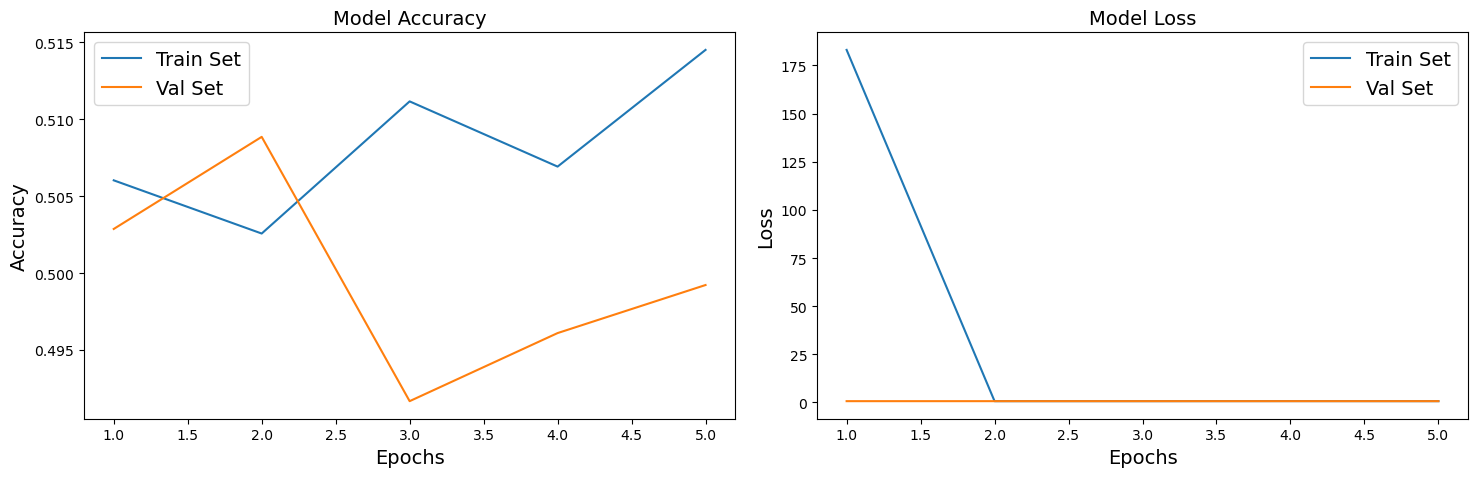

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [19]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [20]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

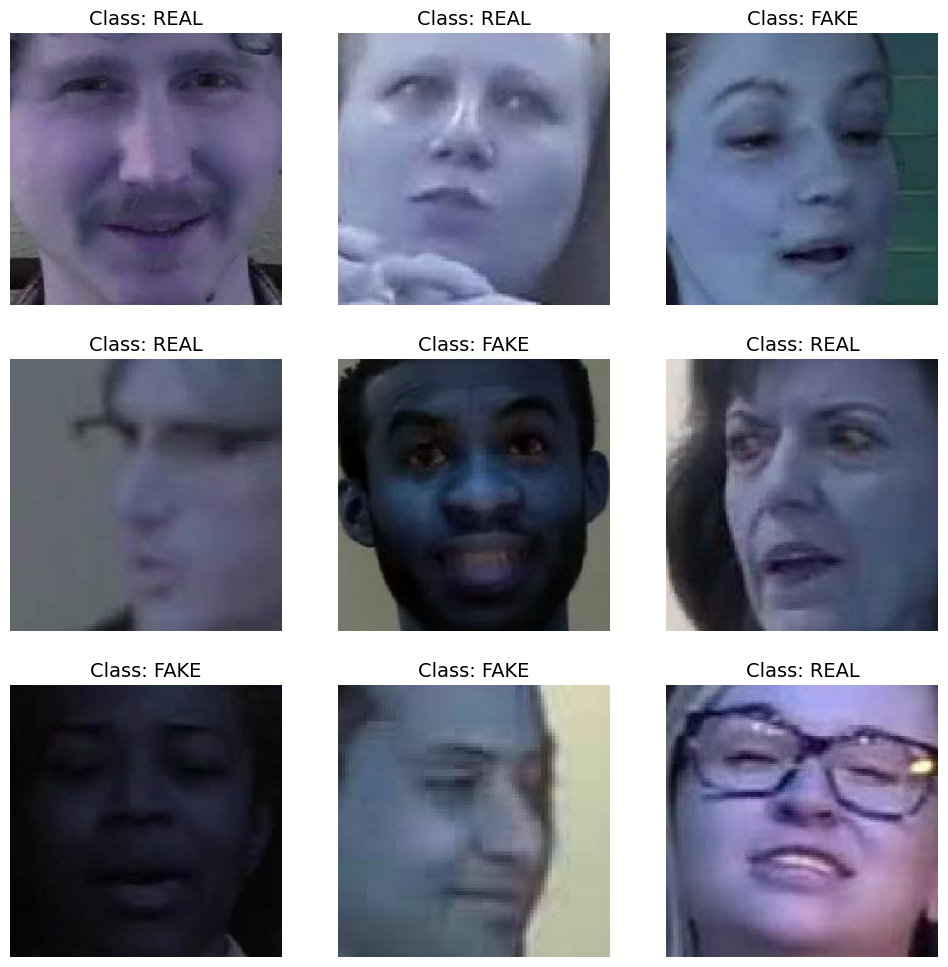

In [21]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

2022-12-03 16:33:55.703704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-12-03 16:33:56.097894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


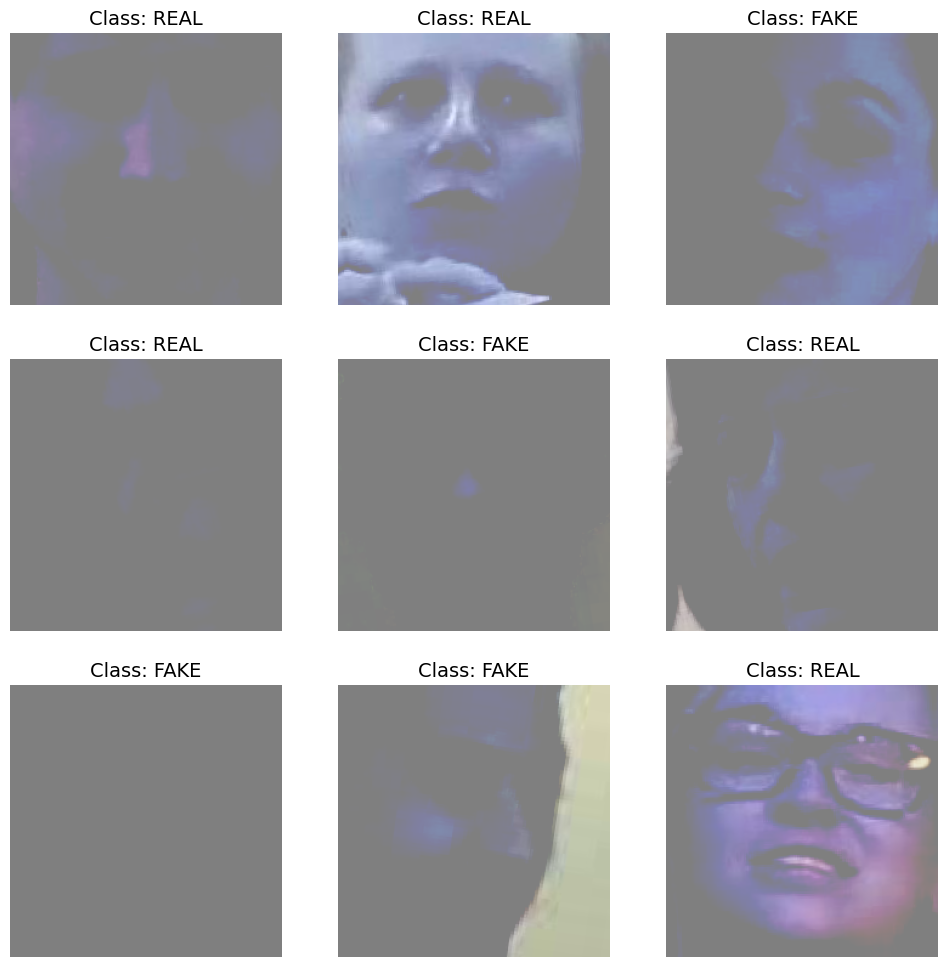

In [23]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [24]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [25]:
for layer in base_model.layers:
    layer.trainable = False

In [26]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3


2022-12-03 16:33:58.344091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


280/280 [==============================] - ETA: 0s - loss: 1.1060 - accuracy: 0.5734

2022-12-03 16:36:48.658060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


280/280 [==============================] - 285s 1s/step - loss: 1.1060 - accuracy: 0.5734 - val_loss: 0.8304 - val_accuracy: 0.6154
Epoch 2/3
280/280 [==============================] - 162s 579ms/step - loss: 0.8956 - accuracy: 0.6124 - val_loss: 0.9378 - val_accuracy: 0.6107
Epoch 3/3
280/280 [==============================] - 208s 743ms/step - loss: 1.0268 - accuracy: 0.6092 - val_loss: 0.9093 - val_accuracy: 0.6341


In [27]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [28]:
model.evaluate(test_set)

100/100 [==============================] - 52s 520ms/step - loss: 0.8852 - accuracy: 0.6316


[0.8852224349975586, 0.6315624713897705]

In [29]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10


2022-12-03 16:45:45.077831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


280/280 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.6715

2022-12-03 16:50:03.476390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


280/280 [==============================] - 320s 1s/step - loss: 0.6139 - accuracy: 0.6715 - val_loss: 0.5154 - val_accuracy: 0.7490
Epoch 2/10
280/280 [==============================] - 319s 1s/step - loss: 0.3226 - accuracy: 0.8574 - val_loss: 0.6104 - val_accuracy: 0.7440
Epoch 3/10
280/280 [==============================] - 322s 1s/step - loss: 0.1742 - accuracy: 0.9334 - val_loss: 0.6123 - val_accuracy: 0.7784
Epoch 4/10
280/280 [==============================] - 327s 1s/step - loss: 0.1090 - accuracy: 0.9604 - val_loss: 0.7220 - val_accuracy: 0.7849
Epoch 5/10
280/280 [==============================] - 326s 1s/step - loss: 0.0808 - accuracy: 0.9710 - val_loss: 1.0554 - val_accuracy: 0.7453
Epoch 6/10
280/280 [==============================] - 330s 1s/step - loss: 0.0659 - accuracy: 0.9777 - val_loss: 1.1684 - val_accuracy: 0.7589
Epoch 7/10
280/280 [==============================] - 337s 1s/step - loss: 0.0483 - accuracy: 0.9833 - val_loss: 0.7297 - val_accuracy: 0.8042
Epoch 8/10

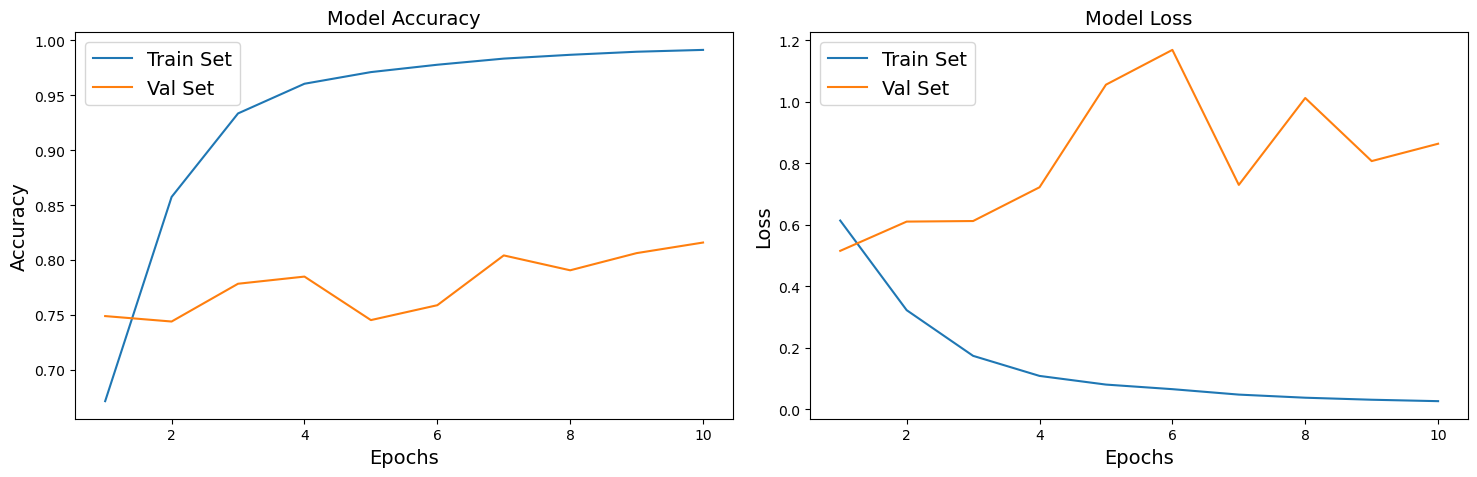

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [31]:
model.evaluate(test_set)

100/100 [==============================] - 55s 550ms/step - loss: 0.7961 - accuracy: 0.8266


[0.7960813641548157, 0.8265624642372131]

In [32]:
model.save('xception_deepfake_image.h5')